# Data Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import timedelta

from datetime import datetime
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials

In [2]:
FILES_DIR = './files/'
total = pd.read_csv(FILES_DIR + 'total.csv')

In [3]:
raw_data = total.copy()

In [4]:
raw_data.drop('Unnamed: 0', axis=1, inplace=True)

# LTV

In [5]:
suc_data = raw_data[raw_data['event_name'] == 'purchase_success'] # 전체고객

In [6]:
ltv_data = suc_data[['user_no', 'event_timestamp', 'price']]
ltv_data['event_timestamp'] = pd.to_datetime(ltv_data['event_timestamp']).dt.date
ltv_data

,user_no,event_timestamp,price
40,l1wFRhb3av5rTWyYEofrIA==,2021-07-22,128000.0
49,l1wFRhb3av5rTWyYEofrIA==,2021-07-22,128000.0
52,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-05,29900.0
53,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-05,29900.0
55,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-10,38000.0
...,...,...,...
5544515,wyp6zUTd+pvmORMJUL+q5A==,2021-08-04,19000.0
5544516,BccBYWyTrdoNwc3A6leNzA==,2021-08-04,89000.0
5544518,01Lx4dn3rhevMsn3FmXm2g==,2021-08-04,15000.0
5544526,8okJXtYVKYoBoBAG823v2Q==,2021-08-04,25000.0


In [7]:
current_date = ltv_data['event_timestamp'].max()

metrics_df = summary_data_from_transaction_data(ltv_data
                                          , customer_id_col = 'user_no'
                                          , datetime_col = 'event_timestamp'
                                          , monetary_value_col='price'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
user_no,,,,
+++T9c17sr6wEYOy9UFv3w==,3.0,18.0,50.0,80200.0
+++aQH5NnhiU/9qECKk3uQ==,1.0,11.0,55.0,68000.0
++0bwiYVJ/TAsCpxI4UCuw==,0.0,0.0,8.0,0.0
++1HN9s1imztN8ftPCt3LA==,0.0,0.0,55.0,0.0
++2StXdzG0Bj/Kkb5EFcog==,0.0,0.0,36.0,0.0


In [8]:
l2_reg = 0.01 # lifetime 공식 홈페이지에서 0.1 ~ 0.001사이값을 넣어주는게 효과적이라고 한다
model = BetaGeoFitter(penalizer_coef=l2_reg)
model = GammaGammaFitter(penalizer_coef=l2_reg)

In [9]:
holdout_days = 15 # 총일수 63일
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(ltv_data
                                          ,customer_id_col = 'user_no'
                                          ,datetime_col = 'event_timestamp'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='price')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_no,,,,,,,
+++T9c17sr6wEYOy9UFv3w==,3.0,18.0,35.0,80200.0,0.0,0.0,15.0
+++aQH5NnhiU/9qECKk3uQ==,1.0,11.0,40.0,68000.0,0.0,0.0,15.0
++1HN9s1imztN8ftPCt3LA==,0.0,0.0,40.0,0.0,0.0,0.0,15.0
++2StXdzG0Bj/Kkb5EFcog==,0.0,0.0,21.0,0.0,0.0,0.0,15.0
++2c5Jr8sOEvXXs326kLYQ==,0.0,0.0,31.0,0.0,0.0,0.0,15.0


In [10]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

In [11]:
# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [12]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials            
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

100%|██████████| 100/100 [00:59<00:00,  1.67trial/s, best loss: 0.5718958919372461]
0.0011297894793220352


In [13]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|██████████| 100/100 [00:26<00:00,  3.73trial/s, best loss: 11380761.987952702]
0.0005610030499176078


In [14]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd) #l2_bgnbd = hyperopt로 나온 결과
# calibration 데이터의 R,F,T로 모형 적합
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal']) 

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))

MSE: 0.5718958919372461


In [15]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,4.642031,0.058606,4.527164,4.756898
alpha,55.816599,0.795910,54.256617,57.376582
a,0.417124,0.017216,0.383381,0.450868
b,0.759298,0.033568,0.693505,0.825091


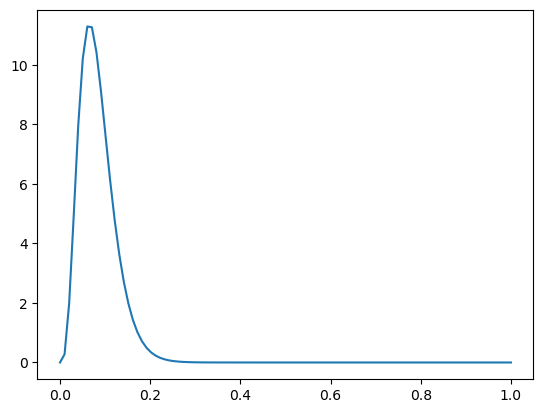

In [16]:
# 고객별 구매율 분포
from scipy.stats import gamma
coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 1, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

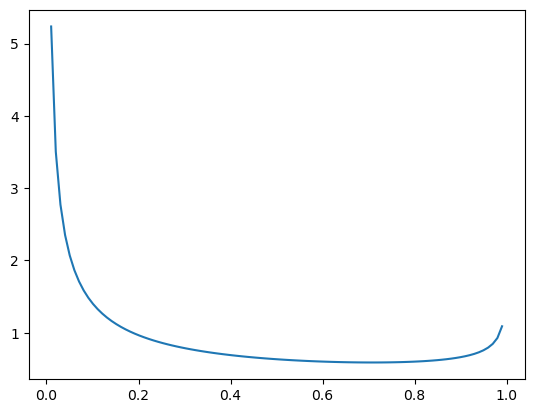

In [17]:
# 고객별 구매하지 않을 분포
from scipy.stats import gamma
from scipy.stats import beta
coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 1, 100) 
y = beta.pdf(x, a=coefs['a'], b=coefs['b']) 

plt.plot(x, y)

In [18]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 11380761.987952702


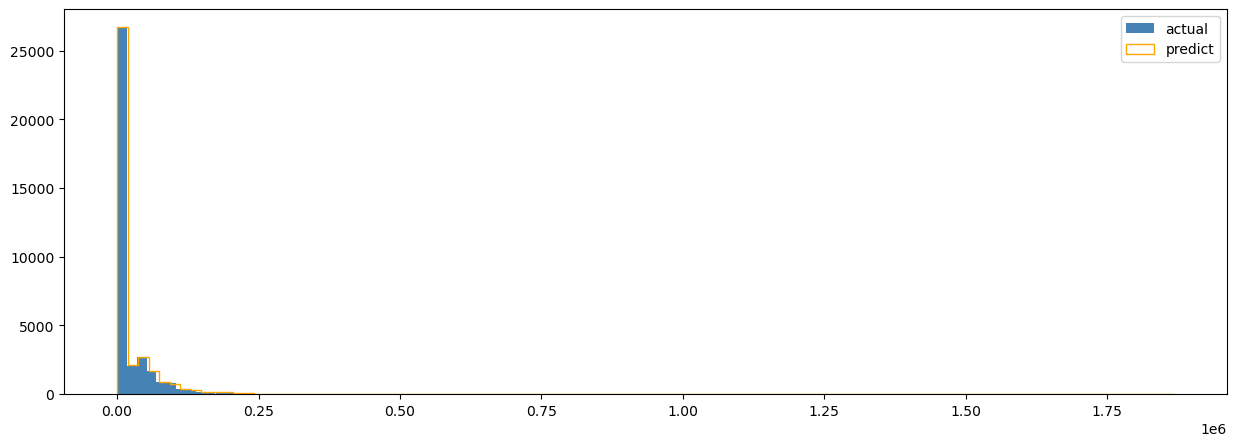

In [19]:
bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

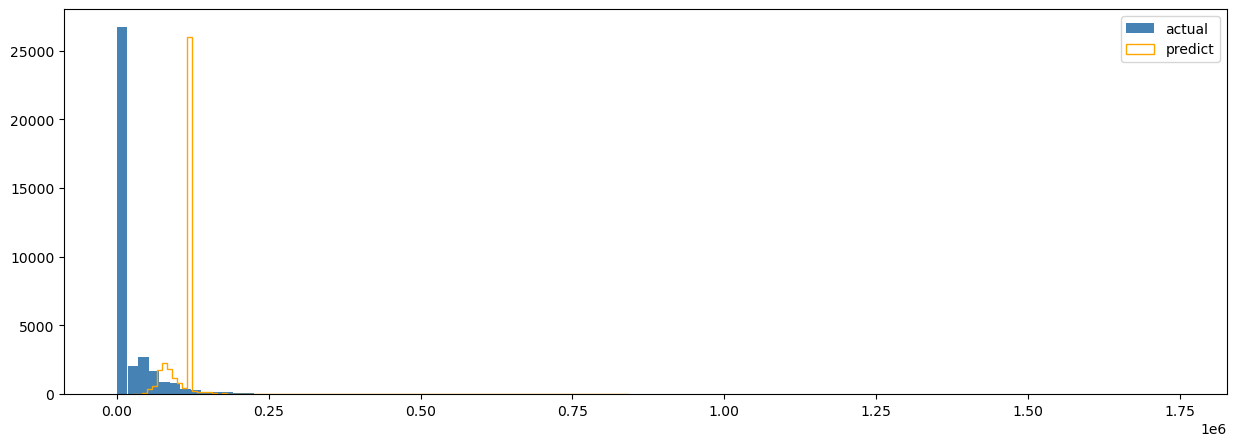

In [20]:
# penalizer_coef 없이 했을 때의 결과
spend_model = GammaGammaFitter(penalizer_coef=0)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# 평가
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

In [21]:
final_df = whole_filtered_df.copy()
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time=12,
                                                     discount_rate=0.01
                                                     )

In [22]:
t=63 
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

In [23]:
final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])

In [140]:
final_df.sort_values(by='frequency', ascending=False)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
user_no,,,,,,,
b/lqkmii6O9hL/CH0kWgLA==,51.0,62.0,62.0,196862.745098,2.158051e+07,26.669460,194965.558408
QYfrbtFOWrk6s0kyW/HAtQ==,49.0,61.0,61.0,161099.795918,1.717083e+07,25.896188,160004.708869
b2xZVfUtjyGsZckO7j6zkg==,43.0,53.0,54.0,675467.441860,6.541203e+07,24.151347,659888.815390
/eBuau3txxONi9xwzcdalg==,31.0,59.0,61.0,240054.838710,1.634472e+07,16.861830,235328.605703
zoCRIwX5o1OHqO4z650ltA==,29.0,62.0,62.0,229420.689655,1.476669e+07,15.945874,224815.403677
...,...,...,...,...,...,...,...
Q506duxD3w35XgWsMhzG4w==,1.0,12.0,34.0,39000.000000,2.200334e+05,0.800415,81775.793332
Q4r24viTwDbVev44FfrMcA==,1.0,6.0,13.0,104000.000000,6.538121e+05,1.809531,110888.147668
Q4ekVY97GSL/pwl7VoMnaQ==,1.0,5.0,14.0,18000.000000,3.859954e+05,1.634262,72370.263470


## frequency를 기준으로 vip고객 나누기

In [84]:
print(final_df.frequency.mean())
print(final_df.frequency.std())
print(final_df.frequency.median())

2.0629158449101666
1.8180830543953739
1.0


In [80]:
# 4번 이상 고객들 분리
vip_customer = final_df[final_df['frequency'] >= 4].sort_values(by='frequency', ascending=False)
non_vip_customer = final_df[final_df['frequency'] < 4].sort_values(by='frequency', ascending=False)

In [82]:
print(vip_customer.frequency.mean())
print(vip_customer.frequency.std())
print(vip_customer.frequency.median())

5.6239123428939735
2.5862779096603608
5.0


In [83]:
print(non_vip_customer.frequency.mean())
print(non_vip_customer.frequency.std())
print(non_vip_customer.frequency.median())

1.50952798297233
0.7091423494617679
1.0


In [85]:
vip_customer_list = vip_customer.reset_index()
vip_customer_list = list(set(vip_customer_list['user_no']))
non_vip_customer_list = non_vip_customer.reset_index()
non_vip_customer_list = list(set(non_vip_customer_list['user_no']))

## vip와 non_vip 나이대 분석

In [ ]:
raw_data = raw_data[raw_data['gender'] != 'un_gender']

In [ ]:
# 나이(age)가 17세 이하인 사용자를 찾아서 age(Group) 컬럼에 "00 ~ 17"이라는 값을 넣어줍니다
raw_data.loc[raw_data['age'] <= 17, 'age(Group)'] = "00 ~ 17"

# 위 방식에 따라 나이 설정 값으로 지정해줍니다
raw_data.loc[(raw_data['age'] >= 18) &\
               (raw_data['age'] <= 24), 'age(Group)'] = "18 ~ 24"

raw_data.loc[(raw_data['age'] >= 25) &\
               (raw_data['age'] <= 35), 'age(Group)'] = "25 ~ 35"

raw_data.loc[(raw_data['age'] >= 36) &\
               (raw_data['age'] <= 44), 'age(Group)'] = "36 ~ 44"

raw_data.loc[(raw_data['age'] >= 45) &\
               (raw_data['age'] <= 54), 'age(Group)'] = "45 ~ 54"

raw_data.loc[raw_data['age'] >= 55, 'age(Group)'] = "55 ~ 99"

# 데이터를 정리 후 아래 2개 컬럼 내용을 확인합니다
raw_data[['age','age(Group)']]

In [ ]:
raw_data['event_timestamp'] = pd.to_datetime(raw_data['event_timestamp'])
raw_data['event_timestamp(weekday)'] = raw_data['event_timestamp'].dt.day_name() # 요일 확인용 컬럼 생성
raw_data[['event_timestamp(weekday)', 'event_timestamp']].head()         

In [86]:
vip_data = raw_data[raw_data['user_no'].isin(vip_customer_list)]
non_vip_data = raw_data[raw_data['user_no'].isin(non_vip_customer_list)]

In [87]:
# pivot_table을 사용하여 index(세로)에는 성별(gender)과 나이(age(Group))를 넣어주고,
# Columns(가로)에는 event_name를 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 혹은 count를 넣어주면 add_to_cart, click_item, like_item, purchase_success의 누적 개수가 나옵니다
vip_table = pd.pivot_table(vip_data,
                       index=['gender', 'age(Group)'],
                       columns='event_name',
                       values='user_no',
                       fill_value=0,
                       aggfunc='count')

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
vip_table['total'] = vip_table['add_to_cart'] + vip_table['click_item'] + vip_table['like_item'] + vip_table['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 purchase_success(구매) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
vip_table['conversion'] = vip_table['purchase_success'] / vip_table['total']


# 이 데이터프레임의 결과를 출력합니다
vip_table#

event_name         add_to_cart  click_item  like_item  purchase_success  \
gender age(Group)                                                         
F      00 ~ 17              26         280        224                43   
       18 ~ 24            1466       36846       1477              3604   
       25 ~ 35           14554      317096      12930             38081   
       36 ~ 44           20966      177845       6636             19843   
       45 ~ 54           16188       80486       4241              7903   
       55 ~ 99            5022       15177        873              1304   
M      00 ~ 17               0          33          0                 8   
       18 ~ 24             569        6285        412               665   
       25 ~ 35            2972       45872       2932              6894   
       36 ~ 44            2741       27572        822              3713   
       45 ~ 54            1093        8675        342              1077   
       55 ~ 99             442        3291         37               308   

event_name          total  conversion  
gender age(Group)                      
F      00 ~ 17        573    0.075044  
       18 ~ 24      43393    0.083055  
       25 ~ 35     382661    0.099516  
       36 ~ 44     225290    0.088078  
       45 ~ 54     108818    0.072626  
       55 ~ 99      22376    0.058277  
M      00 ~ 17         41    0.195122  
       18 ~ 24       7931    0.083848  
       25 ~ 35      58670    0.117505  
       36 ~ 44      34848    0.106548  
       45 ~ 54      11187    0.096272  
       55 ~ 99       4078    0.075527

In [88]:
# pivot_table을 사용하여 index(세로)에는 성별(gender)과 나이(age(Group))를 넣어주고,
# Columns(가로)에는 event_name를 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 혹은 count를 넣어주면 add_to_cart, click_item, like_item, purchase_success의 누적 개수가 나옵니다
non_vip_table = pd.pivot_table(non_vip_data,
                       index=['gender', 'age(Group)'],
                       columns='event_name',
                       values='user_no',
                       fill_value=0,
                       aggfunc='count')

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
non_vip_table['total'] = non_vip_table['add_to_cart'] + non_vip_table['click_item'] + non_vip_table['like_item'] + non_vip_table['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 purchase_success(구매) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
non_vip_table['conversion'] = non_vip_table['purchase_success'] / non_vip_table['total']


# 이 데이터프레임의 결과를 출력합니다
non_vip_table#

event_name         add_to_cart  click_item  like_item  purchase_success  \
gender age(Group)                                                         
F      00 ~ 17              25         613         65                83   
       18 ~ 24            3290      114575       5236             12404   
       25 ~ 35           28120      714427      22610             83828   
       36 ~ 44           40042      326946      13232             36683   
       45 ~ 54           20891      103747       5177             10600   
       55 ~ 99            4013       18580       2089              1629   
M      00 ~ 17             108         339         55                80   
       18 ~ 24            1203       19801       1347              3021   
       25 ~ 35            8303      128944       5785             20929   
       36 ~ 44            5326       57794       1788              9170   
       45 ~ 54            1786       12123        388              2017   
       55 ~ 99             757        3504        224               383   

event_name          total  conversion  
gender age(Group)                      
F      00 ~ 17        786    0.105598  
       18 ~ 24     135505    0.091539  
       25 ~ 35     848985    0.098739  
       36 ~ 44     416903    0.087989  
       45 ~ 54     140415    0.075491  
       55 ~ 99      26311    0.061913  
M      00 ~ 17        582    0.137457  
       18 ~ 24      25372    0.119068  
       25 ~ 35     163961    0.127646  
       36 ~ 44      74078    0.123788  
       45 ~ 54      16314    0.123636  
       55 ~ 99       4868    0.078677

## vip와 non_vip 시간별 분석

In [89]:
# pivot_table을 사용하여 index(세로)에는 event_timestamp_hour를 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
vip_by_hours = pd.pivot_table(vip_data,
                                index='event_timestamp_hour',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
vip_by_hours['total'] = vip_by_hours['add_to_cart'] + vip_by_hours['click_item'] + vip_by_hours['like_item'] + vip_by_hours['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
vip_by_hours['conversion'] = vip_by_hours['purchase_success'] / vip_by_hours['total']

# 결과를 확인합니다
vip_by_hours

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
event_timestamp_hour,,,,,,
0,3868,49476,2133,4839,60316,0.080227
1,2487,33100,1591,3111,40289,0.077217
2,1399,19743,767,1700,23609,0.072006
3,867,11463,624,947,13901,0.068125
4,591,7368,399,595,8953,0.066458
5,500,5997,258,479,7234,0.066215
6,998,8577,481,878,10934,0.080300
7,1717,15531,773,1590,19611,0.081077
8,2457,24729,1147,2818,31151,0.090463


In [90]:
# pivot_table을 사용하여 index(세로)에는 event_timestamp_hour를 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
non_vip_by_hours = pd.pivot_table(non_vip_data,
                                index='event_timestamp_hour',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
non_vip_by_hours['total'] = non_vip_by_hours['add_to_cart'] + non_vip_by_hours['click_item'] + non_vip_by_hours['like_item'] + non_vip_by_hours['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
non_vip_by_hours['conversion'] = non_vip_by_hours['purchase_success'] / non_vip_by_hours['total']

# 결과를 확인합니다
non_vip_by_hours

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
event_timestamp_hour,,,,,,
0,6840,109768,3725,11246,131579,0.085470
1,4376,72740,2829,6905,86850,0.079505
2,2526,44542,1838,4145,53051,0.078132
3,1523,26351,1174,2277,31325,0.072690
4,1048,16670,773,1524,20015,0.076143
5,1039,12383,619,1088,15129,0.071915
6,1583,16593,759,1600,20535,0.077916
7,2869,29985,1216,3042,37112,0.081968
8,4371,47505,1906,5616,59398,0.094549


<Axes: xlabel='event_timestamp_hour', ylabel='conversion'>

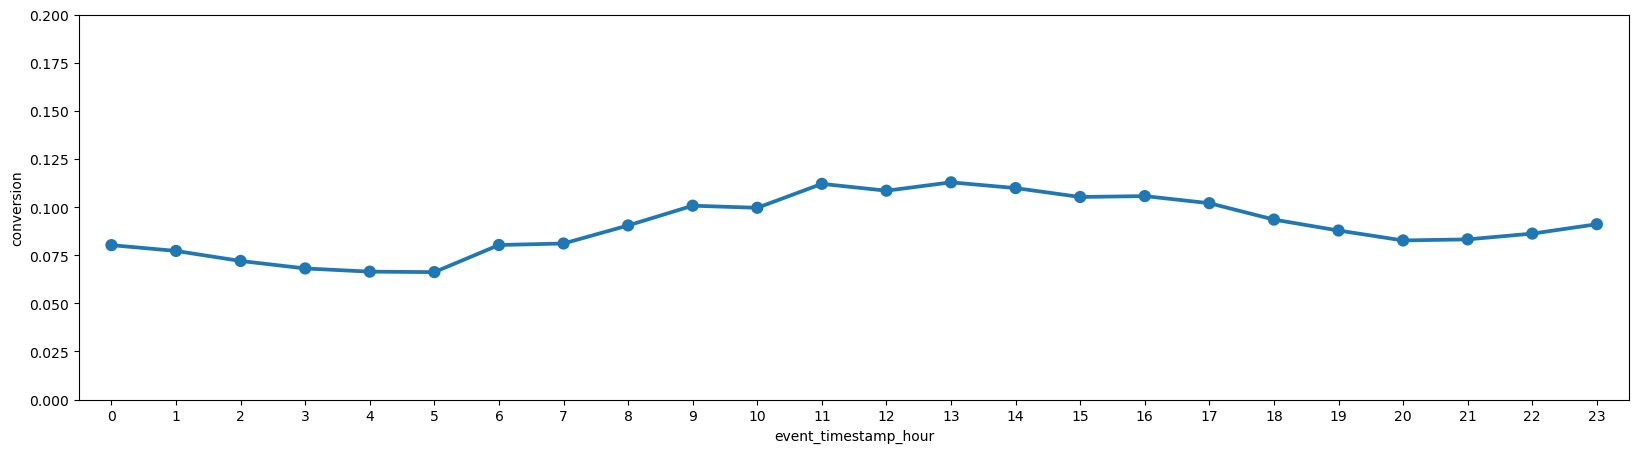

In [91]:
# 그래프 전체 사이즈 설정합니다
plt.figure(figsize=[20,5])

# y축의 최소/최대값을 0/0.2로 고정합니다
plt.ylim(0, 0.2)

# 시간대별 전환율(conversion)을 시각화 합니다
sns.pointplot(data = vip_by_hours.reset_index(), x='event_timestamp_hour', y='conversion')

<Axes: xlabel='event_timestamp_hour', ylabel='conversion'>

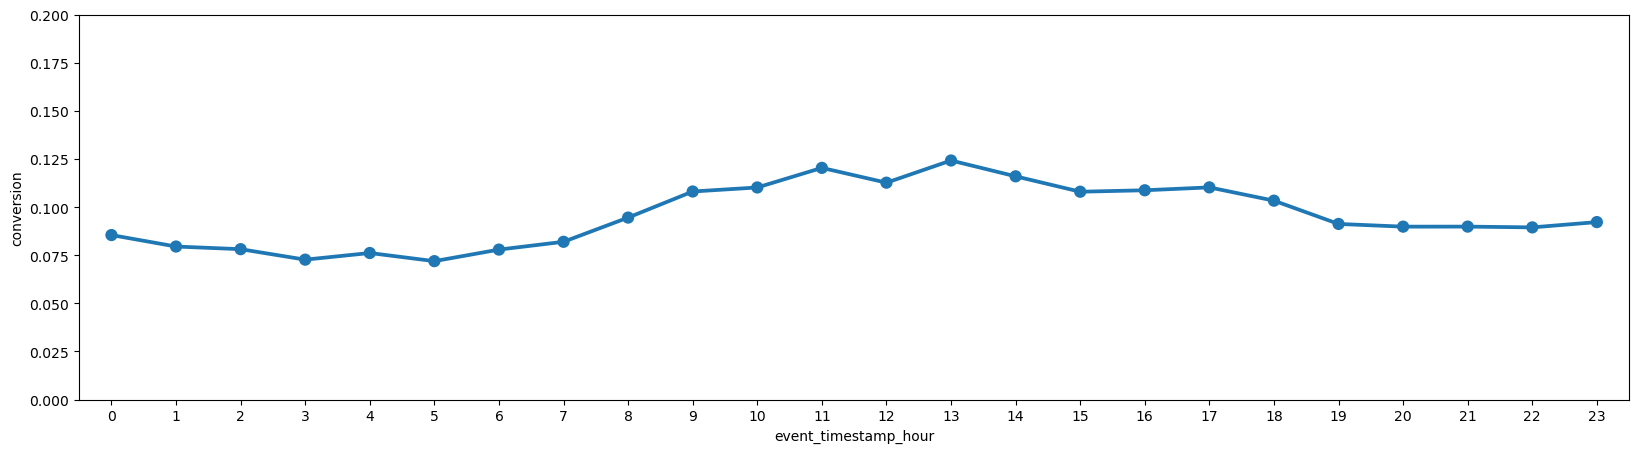

In [92]:
# 그래프 전체 사이즈 설정합니다
plt.figure(figsize=[20,5])

# y축의 최소/최대값을 0/0.2로 고정합니다
plt.ylim(0, 0.2)

# 시간대별 전환율(conversion)을 시각화 합니다
sns.pointplot(data = non_vip_by_hours.reset_index(), x='event_timestamp_hour', y='conversion')

<Axes: xlabel='event_timestamp_hour', ylabel='purchase_success'>

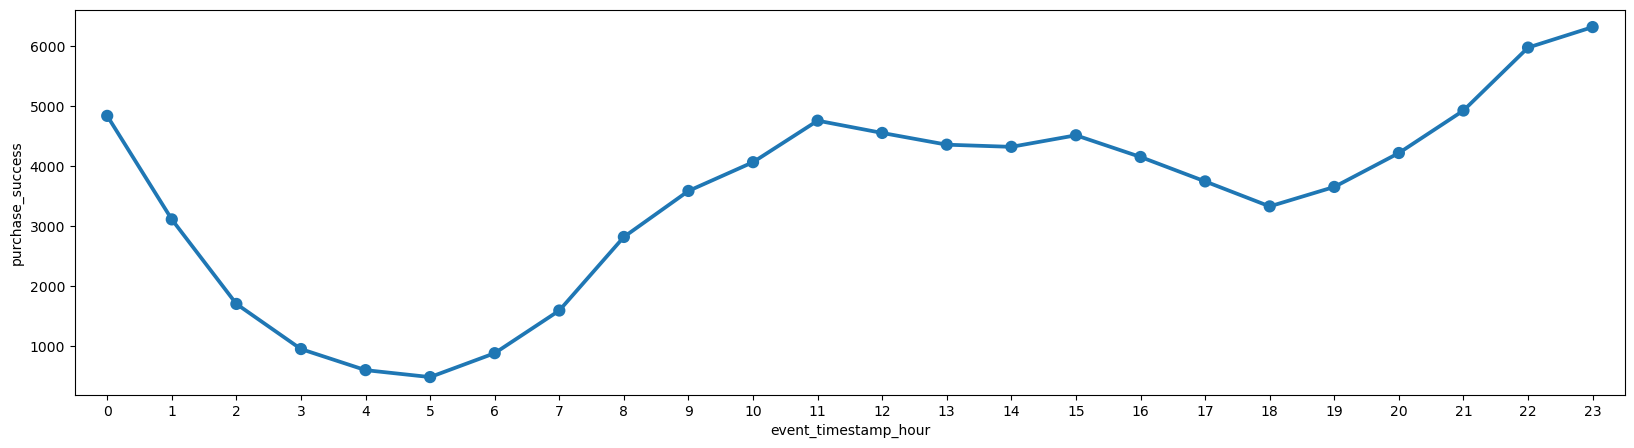

In [93]:
# 그래프 전체 사이즈 설정합니다
plt.figure(figsize=[20,5])

# 시간대별 구매(purchase_success)를 시각화 합니다
sns.pointplot(data = vip_by_hours.reset_index(), x='event_timestamp_hour', y='purchase_success')

<Axes: xlabel='event_timestamp_hour', ylabel='purchase_success'>

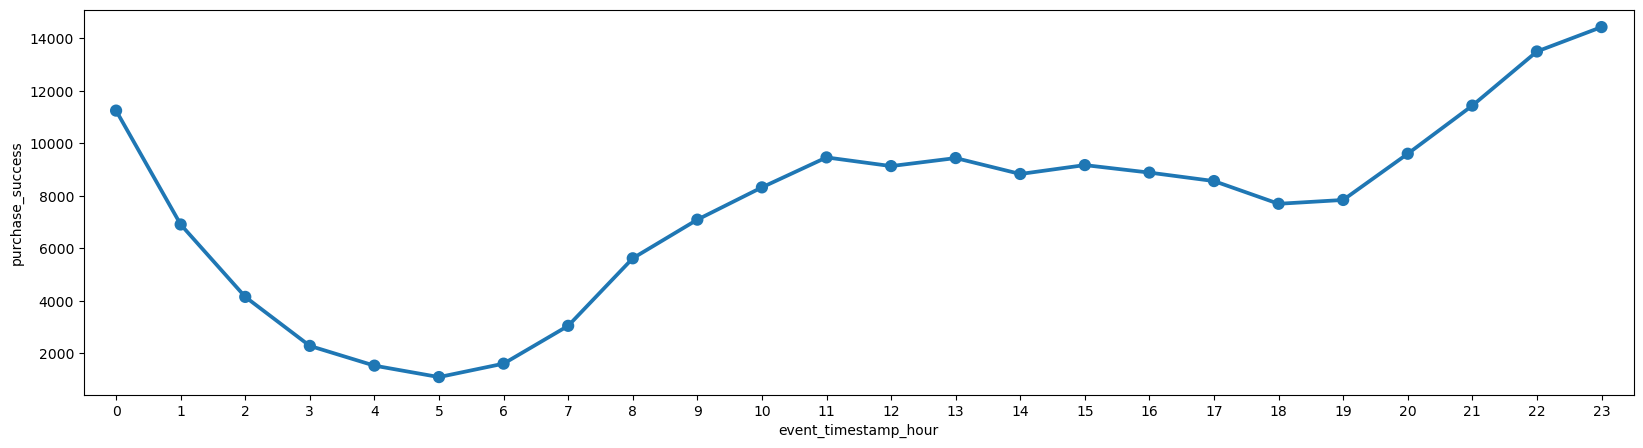

In [94]:
# 그래프 전체 사이즈 설정합니다
plt.figure(figsize=[20,5])

# 시간대별 구매(purchase_success)를 시각화 합니다
sns.pointplot(data = non_vip_by_hours.reset_index(), x='event_timestamp_hour', y='purchase_success')

## vip와 non_vip 요일별 분석

In [95]:
# pivot_table을 사용하여 index(세로)에는 event_timestamp(weekday)를 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
vip_by_week = pd.pivot_table(vip_data,
                                index='event_timestamp(weekday)',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
vip_by_week['total'] = vip_by_week['add_to_cart'] + vip_by_week['click_item'] + vip_by_week['like_item'] + vip_by_week['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
vip_by_week['conversion'] = vip_by_week['purchase_success'] / vip_by_week['total']

# 컬럼 정렬을 위해 새로운 변수를 생성합니다
week_columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# 결과를 확인합니다
vip_by_week.loc[week_columns]

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
event_timestamp(weekday),,,,,,
Sunday,10361,113339,4841,12906,141447,0.091243
Monday,8546,100186,4287,12723,125742,0.101183
Tuesday,9653,105194,4145,12517,131509,0.095180
Wednesday,9582,105464,3906,12692,131644,0.096412
Thursday,8992,94781,4290,12123,120186,0.100869
Friday,9344,95496,4737,10693,120270,0.088908
Saturday,9561,104998,4720,9789,129068,0.075844


In [96]:
# pivot_table을 사용하여 index(세로)에는 event_timestamp(weekday)를 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
non_vip_by_week = pd.pivot_table(non_vip_data,
                                index='event_timestamp(weekday)',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
non_vip_by_week['total'] = non_vip_by_week['add_to_cart'] + non_vip_by_week['click_item'] + non_vip_by_week['like_item'] + non_vip_by_week['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
non_vip_by_week['conversion'] = non_vip_by_week['purchase_success'] / non_vip_by_week['total']

# 컬럼 정렬을 위해 새로운 변수를 생성합니다
week_columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# 결과를 확인합니다
non_vip_by_week.loc[week_columns]

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
event_timestamp(weekday),,,,,,
Sunday,18266,248107,9316,27746,303435,0.091440
Monday,15691,209704,8113,27889,261397,0.106692
Tuesday,16800,220108,8289,29311,274508,0.106776
Wednesday,15605,210936,7767,26789,261097,0.102602
Thursday,15596,196571,8208,25616,245991,0.104134
Friday,14539,195564,7263,22420,239786,0.093500
Saturday,17367,220403,9040,21056,267866,0.078606


<Axes: xlabel='event_timestamp(weekday)', ylabel='conversion'>

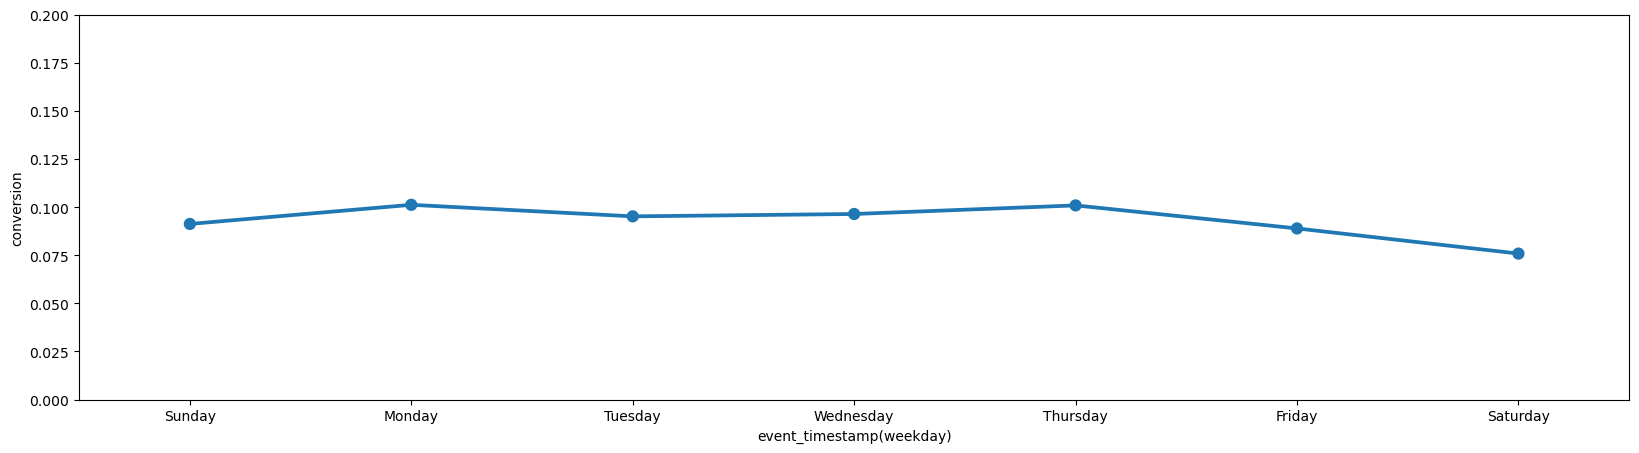

In [97]:
# 가로를 20인치, 세로를 5인치로 조절합니다
plt.figure(figsize=[20,5])

# y축의 최소/최대값을 0/0.2로 고정합니다
plt.ylim(0, 0.2)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다
# X축은 구매 요일(event_timestamp(weekday)))을, y축은 전환율(conversion)을 측정합니다
sns.pointplot(data=vip_by_week.reset_index(), x='event_timestamp(weekday)',\
              y='conversion', order = week_columns)

<Axes: xlabel='event_timestamp(weekday)', ylabel='conversion'>

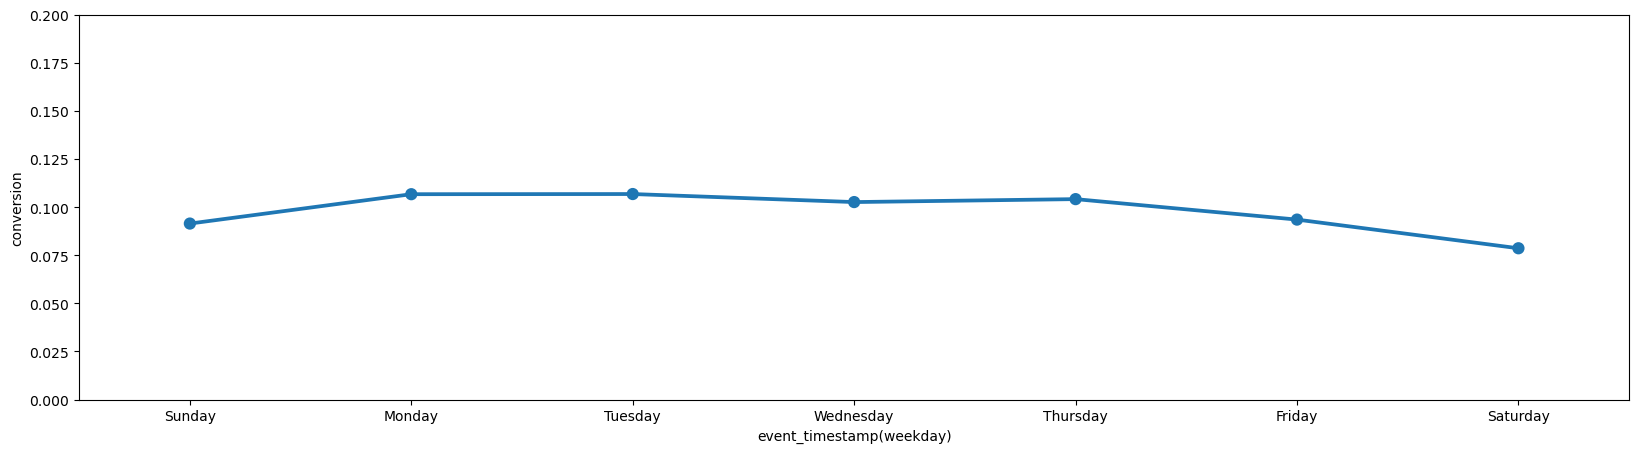

In [98]:
# 가로를 20인치, 세로를 5인치로 조절합니다
plt.figure(figsize=[20,5])

# y축의 최소/최대값을 0/0.2로 고정합니다
plt.ylim(0, 0.2)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다
# X축은 구매 요일(event_timestamp(weekday)))을, y축은 전환율(conversion)을 측정합니다
sns.pointplot(data=non_vip_by_week.reset_index(), x='event_timestamp(weekday)',\
              y='conversion', order = week_columns)

<Axes: xlabel='event_timestamp(weekday)', ylabel='purchase_success'>

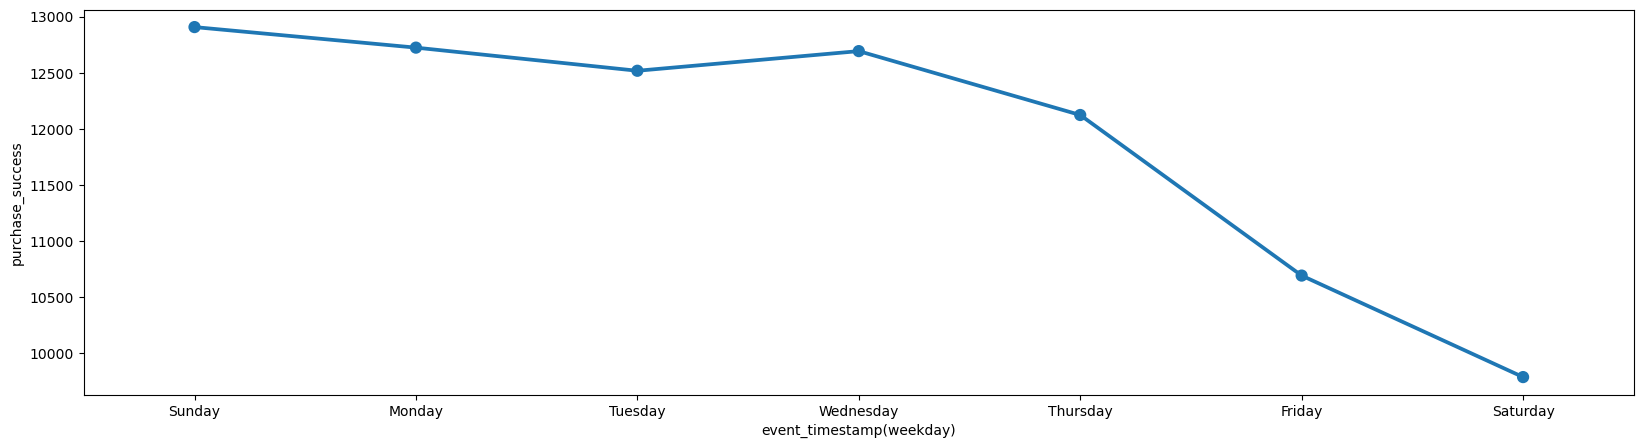

In [99]:
# 가로를 20인치, 세로를 5인치로 조절합니다.
plt.figure(figsize=[20,5])

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다
# X축은 구매 요일(event_timestamp(weekday))을, y축은 구매 완료 (purchase_success)를 측정합니다
sns.pointplot(data=vip_by_week.reset_index(), x='event_timestamp(weekday)',\
              y='purchase_success', order = week_columns)

<Axes: xlabel='event_timestamp(weekday)', ylabel='purchase_success'>

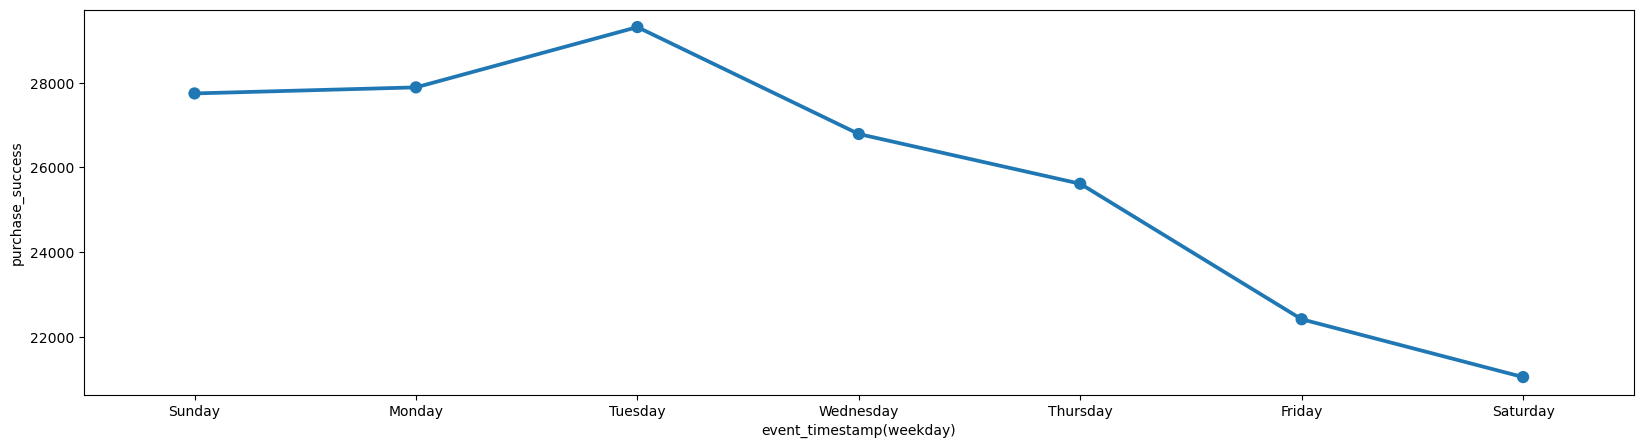

In [100]:
# 가로를 20인치, 세로를 5인치로 조절합니다.
plt.figure(figsize=[20,5])

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다
# X축은 구매 요일(event_timestamp(weekday))을, y축은 구매 완료 (purchase_success)를 측정합니다
sns.pointplot(data=non_vip_by_week.reset_index(), x='event_timestamp(weekday)',\
              y='purchase_success', order = week_columns)

## vip와 non_vip 카테고리 분석

In [101]:
# pivot_table을 사용하여 index(세로)에는 category2_name 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
vip_by_cat2 = pd.pivot_table(vip_data,
                                index='category2_name',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
vip_by_cat2['total'] = vip_by_cat2['add_to_cart'] + vip_by_cat2['click_item'] + vip_by_cat2['like_item'] + vip_by_cat2['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
vip_by_cat2['conversion'] = vip_by_cat2['purchase_success'] / vip_by_cat2['total']

# 결과를 확인합니다
vip_by_cat2.sort_values(by='conversion', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
category2_name,,,,,,
티켓,52,331,55,1127,1565,0.720128
수산,4,10,0,8,22,0.363636
원피스,0,6,0,3,9,0.333333
농산물,28,137,11,83,259,0.320463
선케어,62,164,19,104,349,0.297994
...,...,...,...,...,...,...
여성 쥬얼리_OLD,0,2,0,0,2,0.000000
테크_OLD,0,1,0,0,1,0.000000
공학기기/용품,1,1,0,0,2,0.000000


In [103]:
print(vip_by_cat2.purchase_success.mean())
print(vip_by_cat2.purchase_success.std())
print(vip_by_cat2.purchase_success.median())

869.1979166666666
2566.0585037421088
137.0


In [107]:
vip_suc_3000 = vip_by_cat2[vip_by_cat2['purchase_success'] >= 3000]
vip_suc_3000['purchase_success'].sum() / vip_by_cat2['purchase_success'].sum()

0.615557925769687

In [108]:
vip_suc_3000.sort_values(by='conversion', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
category2_name,,,,,,
언더웨어,1708,14612,487,3356,20163,0.166443
주방용품,3948,21973,1648,4474,32043,0.139625
신발,3687,45974,2113,4767,56541,0.084311
상의,19192,221077,7480,22048,269797,0.081721
하의,9336,118980,3665,10119,142100,0.071210
가방,3198,43995,1943,3575,52711,0.067823
원피스/점프수트,3815,65466,2299,3025,74605,0.040547


In [102]:
# pivot_table을 사용하여 index(세로)에는 category2_name 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
non_vip_by_cat2 = pd.pivot_table(non_vip_data,
                                index='category2_name',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
non_vip_by_cat2['total'] = non_vip_by_cat2['add_to_cart'] + non_vip_by_cat2['click_item'] + non_vip_by_cat2['like_item'] + non_vip_by_cat2['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
non_vip_by_cat2['conversion'] = non_vip_by_cat2['purchase_success'] / non_vip_by_cat2['total']

# 결과를 확인합니다
non_vip_by_cat2.sort_values(by='conversion', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
category2_name,,,,,,
티켓,149,856,131,3268,4404,0.742053
농산물,37,143,21,114,315,0.361905
저장장치,1,30,0,15,46,0.326087
선케어,102,237,34,155,528,0.293561
헤어스타일링,13,61,9,34,117,0.290598
...,...,...,...,...,...,...
여성슈즈_OLD,0,1,0,0,1,0.000000
여행,1,8,2,0,11,0.000000
원피스,2,23,1,0,26,0.000000


In [104]:
print(non_vip_by_cat2.purchase_success.mean())
print(non_vip_by_cat2.purchase_success.std())
print(non_vip_by_cat2.purchase_success.median())

1790.3663366336634
5970.471014455678
205.0


In [111]:
non_vip_suc_6000 = non_vip_by_cat2[non_vip_by_cat2['purchase_success'] >= 6000]
non_vip_suc_6000['purchase_success'].sum() / non_vip_by_cat2['purchase_success'].sum()

0.6255592361760135

In [112]:
non_vip_suc_6000.sort_values(by='conversion', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
category2_name,,,,,,
언더웨어,3339,30921,794,7229,42283,0.170967
주방용품,5312,41622,2121,7532,56587,0.133105
신발,7853,111740,4703,14656,138952,0.105475
상의,34702,464016,14856,53815,567389,0.094847
가방,5757,113159,4820,10330,134066,0.077052
하의,13937,224251,6227,19556,263971,0.074084


In [146]:
suc_data.columns

Index(['session_id', 'event_timestamp', 'event_name', 'user_no', 'item_no',
       'device_type', 'operating_system_version', 'country', 'region',
       'platform', 'event_timestamp_year', 'event_timestamp_month',
       'event_timestamp_day', 'event_timestamp_hour', 'event_timestamp_minute',
       'ostype', 'osversion(number)', 'item_name', 'image_name', 'price',
       'category1_code', 'category1_name', 'category2_code', 'category2_name',
       'category3_code', 'category3_name', 'brand_no', 'brand_name',
       'birth_date', 'gender', 'age'],
      dtype='object')

In [147]:
one_piece_data = suc_data[suc_data['category2_name'] == '원피스/점프수트']

In [149]:
one_piece_data['brand_name'].value_counts()

MONGDOL          1226
LENINA            696
HAE BY HAEKIM     361
DUNST             337
앳코너               334
                 ... 
Tactful Kiosk       1
Buhee               1
LA VIOLETTE         1
WARDROBE            1
DAKS LONDON         1
Name: brand_name, Length: 464, dtype: int64

In [150]:
len(one_piece_data)

13164

In [151]:
1226 / 13164

0.09313278638711638

## vip와 non_vip 브랜드 분석

In [113]:
# pivot_table을 사용하여 index(세로)에는 brand_name 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
vip_by_brand = pd.pivot_table(vip_data,
                                index='brand_name',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
vip_by_brand['total'] = vip_by_brand['add_to_cart'] + vip_by_brand['click_item'] + vip_by_brand['like_item'] + vip_by_brand['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
vip_by_brand['conversion'] = vip_by_brand['purchase_success'] / vip_by_brand['total']

# 결과를 확인합니다
vip_by_brand.sort_values(by='total', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
FACADE PATTERN,625,10840,166,893,12524,0.071303
Nothing written,466,10498,126,1106,12196,0.090685
ANOTHEROFFICE,336,9169,133,775,10413,0.074426
THOMASMORE,810,7952,208,1324,10294,0.128619
LENINA,693,8724,255,523,10195,0.051300
...,...,...,...,...,...,...
블런트,0,1,0,0,1,0.000000
블루워시,0,0,0,1,1,1.000000
VALENTINO_아르떼모아,0,1,0,0,1,0.000000


In [117]:
print(vip_by_brand['total'].mean())
print(vip_by_brand['total'].std())
print(vip_by_brand['total'].median())

149.65341759521039
579.5227861218661
15.0


In [119]:
brand_vip_600 = vip_by_brand[vip_by_brand['total'] > 600].sort_values(by='conversion', ascending=False)
brand_vip_600

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
그라운드시소,24,34,30,793,881,0.900114
UNLIMIT,170,385,19,293,867,0.337947
The Ordinary,106,685,14,404,1209,0.334160
1507,103,627,33,342,1105,0.309502
ontz,163,558,39,336,1096,0.306569
...,...,...,...,...,...,...
MONOCHROME,79,1390,42,32,1543,0.020739
COTTA,63,1635,35,32,1765,0.018130
COVETBLAN,64,1924,45,34,2067,0.016449


In [124]:
print(brand_vip_600['purchase_success'].mean())
print(brand_vip_600['purchase_success'].std())
print(brand_vip_600['purchase_success'].median())

147.83183183183183
175.40085400616533
94.0


In [152]:
# top15
brand_vip_600[brand_vip_600['purchase_success'] > 300].sort_values(by='conversion', ascending=False)[:15]

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
그라운드시소,24,34,30,793,881,0.900114
The Ordinary,106,685,14,404,1209,0.334160
1507,103,627,33,342,1105,0.309502
ontz,163,558,39,336,1096,0.306569
BIARRITZ,209,646,21,322,1198,0.268781
TOPTEN,249,1017,52,439,1757,0.249858
comfortlab,715,3654,106,1467,5942,0.246887
FLUKE,302,842,45,372,1561,0.238309
TAW&TOE_이누,101,1016,27,357,1501,0.237841


In [120]:
# pivot_table을 사용하여 index(세로)에는 brand_name 넣어주고,
# Columns(가로)에는 event_name 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 를 넣어주면 click_item, add_to_cart, like_item, purchase_success 누적 개수가 나옵니다
non_vip_by_brand = pd.pivot_table(non_vip_data,
                                index='brand_name',
                                columns='event_name',
                                values='user_no',
                                fill_value=0,
                                aggfunc=len)

# add_to_cart, click_item, like_item, purchase_success 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가합니다
non_vip_by_brand['total'] = non_vip_by_brand['add_to_cart'] + non_vip_by_brand['click_item'] + non_vip_by_brand['like_item'] + non_vip_by_brand['purchase_success']

# 위에서 추가한 total이라는 컬럼으로 completed(결제 완료) 컬럼을 나누면 결제 확률, 전환율(Conversion)이 나옵니다
non_vip_by_brand['conversion'] = non_vip_by_brand['purchase_success'] / non_vip_by_brand['total']

# 결과를 확인합니다
non_vip_by_brand.sort_values(by='total', ascending=False)

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
THOMASMORE,1708,18182,445,3317,23652,0.140242
FACADE PATTERN,867,19831,325,1346,22369,0.060173
LENINA,1191,19181,689,924,21985,0.042029
ANOTHEROFFICE,721,18610,280,1883,21494,0.087606
DUNST,931,17534,360,1255,20080,0.062500
...,...,...,...,...,...,...
Sistertalk,0,0,1,0,1,0.000000
오뜨 디기리 독,0,1,0,0,1,0.000000
Samsung_회산디지털_홈터뷰,0,1,0,0,1,0.000000


In [121]:
print(non_vip_by_brand['total'].mean())
print(non_vip_by_brand['total'].std())
print(non_vip_by_brand['total'].median())

279.31304609822234
1141.0134850269749
20.0


In [126]:
non_vip_by_brand_1300 = non_vip_by_brand[non_vip_by_brand['total'] > 1300].sort_values(by='conversion', ascending=False)
non_vip_by_brand_1300

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
그라운드시소,76,98,79,2411,2664,0.905030
le2,239,778,75,625,1717,0.364007
UNLIMIT,590,1335,97,1111,3133,0.354612
ontz,406,1679,155,1066,3306,0.322444
The Ordinary,265,1506,47,856,2674,0.320120
...,...,...,...,...,...,...
homeropero,207,3564,87,60,3918,0.015314
vem ver,131,3676,110,53,3970,0.013350
POTTERY(매입),19,2315,11,31,2376,0.013047


In [131]:
print(non_vip_by_brand_1300['purchase_success'].mean())
print(non_vip_by_brand_1300['purchase_success'].std())
print(non_vip_by_brand_1300['purchase_success'].median())

356.42088607594934
459.78811207645606
218.5


In [153]:
# top15
non_vip_by_brand_1300[non_vip_by_brand_1300['purchase_success'] > 800].sort_values(by='conversion', ascending=False)[:15]

event_name,add_to_cart,click_item,like_item,purchase_success,total,conversion
brand_name,,,,,,
그라운드시소,76,98,79,2411,2664,0.905030
UNLIMIT,590,1335,97,1111,3133,0.354612
ontz,406,1679,155,1066,3306,0.322444
The Ordinary,265,1506,47,856,2674,0.320120
FLUKE,778,2877,158,1676,5489,0.305338
1507,353,1780,85,963,3181,0.302735
comfortlab,1540,8967,200,3608,14315,0.252043
ALVINCLO,888,3242,168,1426,5724,0.249126
TAW&TOE_이누,310,3128,89,1145,4672,0.245077


## vip와 non_vip 체류시간 분석

In [136]:
vip_data['event_timestamp'] = pd.to_datetime(vip_data['event_timestamp'])
vip_data['event_timestamp'] = vip_data['event_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
vip_data['event_timestamp'] = pd.to_datetime(vip_data['event_timestamp'])

max_group = vip_data.groupby(['session_id', 'user_no'])['event_timestamp'].max()
min_group = vip_data.groupby(['session_id', 'user_no'])['event_timestamp'].min()

max_time = pd.DataFrame(max_group)
max_time.columns = ['latest']

min_time = pd.DataFrame(min_group)
min_time.columns = ['start']

vip_max_min = pd.concat([max_time, min_time], axis=1)

vip_max_min['session_time'] = vip_max_min['latest'] - vip_max_min['start']

vip_max_min.sort_values(by='session_time', ascending=False)

,,latest,start,session_time
session_id,user_no,,,
eae91320e3b251f99996c16b28f1d828,UxbJuWLml+M4McU8Q5hNqA==,2021-06-24 21:51:24,2021-06-24 14:39:37,0 days 07:11:47
e38978aa44622266a3412441108bdfab,b2xZVfUtjyGsZckO7j6zkg==,2021-06-15 20:52:33,2021-06-15 13:51:38,0 days 07:00:55
78e3eb0b90870bd078cc17e3b02d5922,b2xZVfUtjyGsZckO7j6zkg==,2021-07-04 01:04:45,2021-07-03 19:25:48,0 days 05:38:57
815d35c81201f4d881ef3a71e06cc221,DYNvLcoA3LAg4XxUzFizRQ==,2021-07-22 02:50:58,2021-07-21 22:04:07,0 days 04:46:51
17e576b27e1b466d2931df18d286f312,u8fsExoIMYNO99+vcR0+5A==,2021-07-01 09:46:23,2021-07-01 05:18:01,0 days 04:28:22
...,...,...,...,...
997b5c83795ec9536b481a835e920fce,MKl3pUU6aiaNead8qvFDIg==,2021-06-20 03:00:01,2021-06-20 03:00:01,0 days 00:00:00
997b04691aa66c47aeebb2f21e7d8860,muRh0k3X6Lkk7M73oFhXWw==,2021-07-13 13:35:28,2021-07-13 13:35:28,0 days 00:00:00
997a849750f8e5ad662c441b8b500e90,OGTDjK5u2u1UqTl3ZTa1qA==,2021-07-06 22:20:31,2021-07-06 22:20:31,0 days 00:00:00


In [137]:
print(vip_max_min['session_time'].mean())
print(vip_max_min['session_time'].std())
print(vip_max_min['session_time'].median())

0 days 00:06:51.543722902
0 days 00:13:19.061125473
0 days 00:01:15


In [138]:
non_vip_data['event_timestamp'] = pd.to_datetime(non_vip_data['event_timestamp'])
non_vip_data['event_timestamp'] = non_vip_data['event_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
non_vip_data['event_timestamp'] = pd.to_datetime(non_vip_data['event_timestamp'])

max_group = non_vip_data.groupby(['session_id', 'user_no'])['event_timestamp'].max()
min_group = non_vip_data.groupby(['session_id', 'user_no'])['event_timestamp'].min()

max_time = pd.DataFrame(max_group)
max_time.columns = ['latest']

min_time = pd.DataFrame(min_group)
min_time.columns = ['start']

non_vip_max_min = pd.concat([max_time, min_time], axis=1)

non_vip_max_min['session_time'] = non_vip_max_min['latest'] - non_vip_max_min['start']

non_vip_max_min.sort_values(by='session_time', ascending=False)

,,latest,start,session_time
session_id,user_no,,,
25e2e4f45831abf4a40216d7ab2e6135,b6cqBnzKGYriIJ3rgkGhZg==,2021-07-20 00:25:14,2021-07-19 18:24:36,0 days 06:00:38
0a21fcc9ec3b9093d06f7aefb86afd34,b6cqBnzKGYriIJ3rgkGhZg==,2021-07-31 09:22:45,2021-07-31 04:26:44,0 days 04:56:01
a71f6aa39219ee16b5cf3851e5740140,3RJ/QUVdRasoG2+CsN+wqg==,2021-06-18 04:13:14,2021-06-17 23:28:31,0 days 04:44:43
2a307e6985c82c6245bc0b3186cdf9bc,59gUG1kNaW1GNZJmHqsy5Q==,2021-07-17 00:14:07,2021-07-16 20:03:27,0 days 04:10:40
a8b367647fa4b0a010bd55f079811b97,W8gouKEQ3Z8IU4oFWgrEYw==,2021-07-03 18:47:26,2021-07-03 14:58:04,0 days 03:49:22
...,...,...,...,...
7c0549088ac2fd52551b3054f7a63359,VThX/eZX3K3psyQvzXi50Q==,2021-06-27 15:33:48,2021-06-27 15:33:48,0 days 00:00:00
7c0592c54922f74a220a56e9b8d11bc1,L/05hVOGj+H+rRm2VR9DMA==,2021-08-02 11:33:09,2021-08-02 11:33:09,0 days 00:00:00
7c05ba1de8e0038cd77c7940dc051be8,Mq/8X3pi5DXfHi5GswU8Bw==,2021-08-02 21:00:19,2021-08-02 21:00:19,0 days 00:00:00


In [139]:
print(non_vip_max_min['session_time'].mean())
print(non_vip_max_min['session_time'].std())
print(non_vip_max_min['session_time'].median())

0 days 00:05:53.409643597
0 days 00:11:42.381593117
0 days 00:00:54
